There are 3 simple steps:
> 1. The first one is the encoding of data
> 2. The application of layers or ansatz
> 3. Measurement

For the first steps, we have options like:
1. Angle encoding
2. Ampitude encoding
3. Quantum phase encoding
4. Hybrid encoding

I am going to use angle encoding, but first identify the data sets. Split your data into two sets:
1. The first one would be training data
2. The second one would be testing data

In [3]:
#import
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [383]:
#here we have just 10 end points between 0 and 2π
#the training and test data both have 10 data points

# We create the training Data
X = np.linspace(0, 2*np.pi, 20) # 5 input datapoints from 0 to 2pi
# We tell the optimizer that this is an input datapoint,
# and not a parameter to optimize over.
X.requires_grad = False
#the labels for our data points follow a sine fucntion
Y = np.sin(X) # The outputs for the input datapoints

# We create the test Data
# 5 test datapoints, shifted from the training data by 0.2
X_test = np.linspace(0.2, 2*np.pi+0.2, 20)
Y_test = np.sin(X_test) # The outputs for the test datapoints

In [385]:
# Step 1 - Create the device
# Here we use the 'default.qubit' simulator and 1 qubit (wires=1)
dev = qml.device('default.qubit', wires=1)

In [388]:
#encoding of data
def state_preparation(x):
    qml.RX(x, wires=0)

In [390]:
#encoding of data
#def state_preparation(x):
 #   qml.PhaseShift(x, wires=0)

In the second step, we have to implement a quantum circuit. There are several options available for this task.
1. Quantum Phase Estimation
2. Variational Quantum Circuit
3. Quantum Fourier Transform

Let's go with VQC approach. We know from tutorials that in this approach, we first have to define layers then we will define the quantum circuit.

## Tunning the circuit a bit

In [394]:
#step 2 would be to define
#def layer(params):
 #   qml.Rot(*params[0], wires=0)
#now we will come towards our variational circuit
#@qml.qnode(dev)
#def circuit(params, x):
 #   state_preparation(x)
#
 #   for param in params:
  #      layer(param)

   # return qml.expval(qml.PauliZ(0))

In [396]:
num_layers = 2


In [398]:
#now we will come towards our variational circuit
#@qml.qnode(dev)
#def circuit(params, x):
 #   state_preparation(x)

  #  for layer in range(num_layers):
   #     qml.Rot(params[layer][0], params[layer][1], params[layer][2], wires=0)
    #return qml.expval(qml.PauliZ(0))

## need to do something about the circuit in terms of params

In [401]:
#def layer(layer_weights):
 #   for wire in range(1):
  #      qml.Rot(*layer_weights[wire], wires=wire)

In [403]:
#now we will come towards our variational circuit
@qml.qnode(dev)
def circuit(params, x):
    state_preparation(x)
    #qml.Rot(params[0], params[1], params[2], wires=0)
    #for layer in range(num_layers):
     #   qml.Rot(params[layer][0], params[layer][1], params[layer][2], wires=0)
    qml.Rot(params[0], params[1], params[2], wires=0)
   # for param in params:
    #    layer(param)
    return qml.expval(qml.PauliZ(0))

Now the next step would be to involve classical post-processing. For this we will introduce cost and loss function.

In [406]:
# Step 3 - Classical Pre/Postprocessing
def loss_func(predictions):
    # This is a postprocessing step. Here we use a least squares metric
    # based on the predictions of the quantum circuit and the outputs
    # of the training data points.

    total_losses = 0
    for i in range(len(Y)):
        output = Y[i]
        prediction = predictions[i]
        loss = (prediction - output)**2
        total_losses += loss
    return total_losses

In [408]:
# Step 4 - Define your cost function, including any classical pre/postprocessing
def cost_fn(params):
    # We get the predictions of the quantum circuit for a specific
    # set of parameters along the entire input dataset
    predictions = [circuit(params, x)  for x in X]
    # We calculate the cost including any classical postprocessing
    cost = loss_func(predictions)
    return cost

Now we are moving towards final steps, we have to define some optimizer. Let's have a look at the optimizer provided by PennyLane. I'm going to use AddAGrad optimizer. 

In [411]:
# Steps 5.1 and 5.2  - We define the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.035)

In [413]:
num_qubits = 1
num_layers = 2
#params = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)

In [415]:
# Step 5.3 We make an initial guess for the parameters
params = np.array([0.1,0.1,0.1],requires_grad=True)

In [417]:
# Step 5.4 - We iterate over a number of defined steps (100)
for i in range (100):
    # Over each step the parameters change to give a better cost
    params, prev_cost = opt.step_and_cost(cost_fn,params)
    if i%10 == 0:
         # We print the result after every 10 steps
        print(f'Step = {i} Cost = {cost_fn(params)}')

Step = 0 Cost = 19.949010667543778
Step = 10 Cost = 0.07506389121242282
Step = 20 Cost = 0.01525761217767553
Step = 30 Cost = 0.006419162830290656
Step = 40 Cost = 0.0035241327081622226
Step = 50 Cost = 0.002225522018171808
Step = 60 Cost = 0.0015327236301119096
Step = 70 Cost = 0.0011198078565069563
Step = 80 Cost = 0.0008539496802029551
Step = 90 Cost = 0.0006727373846035483


In [418]:
# Step 6 - Test and graph your results!
test_predictions = []
for x_test in X_test:
    prediction = circuit(params, x_test)
    test_predictions.append(prediction)

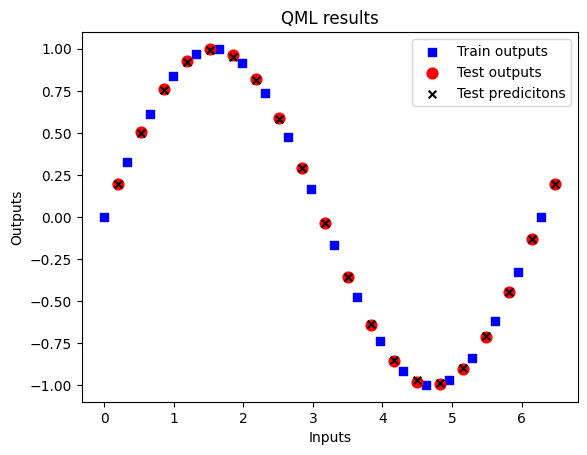

In [419]:
#plotting 

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X, Y, s=30, c='b', marker="s", label='Train outputs')
ax1.scatter(X_test,Y_test, s=60, c='r', marker="o", label='Test outputs')
ax1.scatter(X_test,test_predictions, s=30, c='k', marker="x", label='Test predicitons')
plt.xlabel("Inputs")
plt.ylabel("Outputs")
plt.title("QML results")

plt.legend(loc='upper right');
plt.show()

The model predicted solely wrong values :(

## Changing the step size significantly improves the model.

Increasing the number of points and changing the step-size significantly improved the outcome